In [1]:
!pip install scikit-optimize
!pip install shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install shap
!pip install tabpfn

In [4]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, brier_score_loss)
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange

from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from tabpfn import TabPFNClassifier
from sklearn.calibration import CalibratedClassifierCV

import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.calibration import calibration_curve

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

pd.set_option('display.max_rows', None)

# Data preprocessing

In [5]:
#Open csv file.

data = pd.read_csv("/content/drive/MyDrive/HCMP-ML/results.csv", index_col=0)
data.head()

,Outcome,LGE_original_shape_Elongation,LGE_original_shape_Flatness,LGE_original_shape_LeastAxisLength,LGE_original_shape_MajorAxisLength,LGE_original_shape_Maximum2DDiameterColumn,LGE_original_shape_Maximum2DDiameterRow,LGE_original_shape_Maximum2DDiameterSlice,LGE_original_shape_Maximum3DDiameter,LGE_original_shape_MeshVolume,...,Cine_wavelet-LLL_gldm_GrayLevelNonUniformity,Cine_wavelet-LLL_gldm_GrayLevelVariance,Cine_wavelet-LLL_gldm_HighGrayLevelEmphasis,Cine_wavelet-LLL_gldm_LargeDependenceEmphasis,Cine_wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,Cine_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,Cine_wavelet-LLL_gldm_LowGrayLevelEmphasis,Cine_wavelet-LLL_gldm_SmallDependenceEmphasis,Cine_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,Cine_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
Image,,,,,,,,,,,,,,,,,,,,,
HCMP_002/HCMP_002_LGE.nii,1,0.444470,0.429530,37.993277,88.453121,43.019702,76.588007,73.655850,77.224674,7589.383015,...,85.661157,0.613363,6.780992,46.735537,347.020661,9.632576,0.255223,0.057390,0.376181,0.015016
HCMP_003/HCMP_003_LGE.nii,0,0.844023,0.000000,0.000000,51.776533,40.312499,42.552082,47.084542,47.084542,6466.115407,...,150.572581,0.205499,3.310484,42.604839,149.552419,15.908266,0.435820,0.046256,0.177192,0.020242
HCMP_005/HCMP_005_LGE.nii,0,0.742572,0.000000,0.000000,11.393415,12.754357,11.629872,12.517349,14.614922,584.300886,...,3.511628,3074.660718,8925.131783,2.666667,15533.085270,0.006264,0.005535,0.709343,7843.086079,0.005384
HCMP_006/HCMP_006_LGE.nii,0,0.763793,0.000000,0.000000,8.155781,9.048693,9.048693,8.170249,9.758557,214.277018,...,8.333333,0.222222,2.000000,18.333333,33.733333,14.483333,0.750000,0.087601,0.183101,0.063726
HCMP_007/HCMP_007_LGE.nii,0,0.242753,0.116949,10.093608,86.307662,30.065214,31.589991,12.038801,76.351395,1470.544827,...,52.747748,0.699456,3.045045,55.324324,76.972973,51.224099,0.710836,0.067721,0.427770,0.028141


In [6]:
#Define predictor variables (x) and outcome of interest (y).

x = data.drop(['Outcome'], axis = 1)
y = data['Outcome']

In [7]:
#Check data shapes.

print(y.shape)
print(x.shape)

(56,)
(56, 1612)


In [8]:
def bootstrap_ci(metric_list, n_bootstraps=1000, alpha=0.05):
    bootstrapped_metrics = []
    for _ in range(n_bootstraps):
        bootstrapped_metric = np.mean(resample(metric_list, replace=True, n_samples=len(metric_list)))
        bootstrapped_metrics.append(bootstrapped_metric)

    lower_bound = np.percentile(bootstrapped_metrics, alpha / 2 * 100)
    upper_bound = np.percentile(bootstrapped_metrics, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [9]:
# Initialize 5-fold cross-validator.

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=31)

In [10]:
from sklearn.linear_model import Lasso
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [11]:
def select_features_using_lasso(X_train, y_train, alpha=0.005):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    selected_features = X_train.columns[lasso.coef_ != 0]
    return selected_features

feature_counter = Counter()

for train_index, _ in cv.split(x, y):

    X_train_fold, _ = x.iloc[train_index], x.iloc[train_index]
    y_train_fold, _ = y.iloc[train_index], y.iloc[train_index]

    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(X_train_fold, y_train_fold, test_size = 0.2, random_state = 31)

    # Min-max scaling the training fold.
    scaler = MinMaxScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_train_fold_scaled = pd.DataFrame(X_train_fold_scaled, columns=X_train_fold.columns, index=X_train_fold.index)

    selected_features = select_features_using_lasso(X_train_fold_scaled, y_train_fold)
    feature_counter.update(selected_features)

# Select features that were chosen in a majority of the folds.
selected_features_final = [feat for feat, count in feature_counter.items() if count > (cv.get_n_splits() / 4)]

# Save the selected features to a txt file
with open("/content/drive/MyDrive/HCMP-ML/selected_features.txt", "w") as file:
    for feature in selected_features_final:
        file.write(feature + "\n")

print(selected_features_final)

['LGE_wavelet-LLH_glrlm_ShortRunLowGrayLevelEmphasis', 'LGE_wavelet-HHH_firstorder_Kurtosis', 'LGE_wavelet-HHH_glszm_LargeAreaLowGrayLevelEmphasis', 'Cine_wavelet-LLH_glszm_SizeZoneNonUniformityNormalized', 'Cine_wavelet-LHL_glcm_MCC', 'Cine_wavelet-HLL_firstorder_Kurtosis', 'Cine_wavelet-HLH_glcm_Correlation', 'Cine_wavelet-HLH_glszm_SmallAreaLowGrayLevelEmphasis', 'LGE_wavelet-LLH_glszm_LargeAreaHighGrayLevelEmphasis', 'LGE_wavelet-HHH_glcm_InverseVariance', 'Cine_original_firstorder_Skewness', 'Cine_wavelet-HLL_firstorder_Skewness', 'Cine_wavelet-HLL_glcm_Idn', 'Cine_wavelet-HHL_glcm_Idn', 'Cine_wavelet-LLL_glcm_InverseVariance', 'Cine_wavelet-LHL_firstorder_Skewness', 'LGE_wavelet-LHH_firstorder_Kurtosis', 'LGE_wavelet-HHL_firstorder_Kurtosis']


In [12]:
# Create empty lists to store metrics for each fold.

precision_list = []
recall_list = []
f1_list = []
acc_list = []
mcc_list = []
auroc_list = []
auprc_list = []
tpr_list = []
prc_list = []
brier_list = []
true_probs_list = []
pred_probs_list = []

aggregate_cm = np.zeros((2,2))
base_fpr = np.linspace(0, 1, 101)

In [13]:
# Perform cross-validation with k-fold CV using the best parameters.

for train_index, test_index in cv.split(x, y):
    X_train_fold, X_test_fold = x[selected_features_final].iloc[train_index], x[selected_features_final].iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(X_train_fold, y_train_fold, test_size = 1/8, random_state = 31)

    print(X_train_fold.shape)

    resampler = SMOTE(random_state = 0)
    X_train_fold, y_train_fold = resampler.fit_resample(X_train_fold, y_train_fold)

    print(X_train_fold.shape)

    tabpfn = TabPFNClassifier(device='cuda', N_ensemble_configurations=8)
    tabpfn.fit(X_train_fold, y_train_fold)

    calibrated = CalibratedClassifierCV(tabpfn, method='isotonic', cv='prefit')
    calibrated.fit(X_valid_fold, y_valid_fold)

    preds = calibrated.predict(X_test_fold.values)
    probs = calibrated.predict_proba(X_test_fold.values)
    probs = probs[:, 1]

    true_probs_list.extend(y_test_fold)
    pred_probs_list.extend(probs)

    # Calculate performance metrics.

    precision_list.append(precision_score(y_test_fold, preds))
    recall_list.append(recall_score(y_test_fold, preds))
    f1_list.append(f1_score(y_test_fold, preds))
    acc_list.append(accuracy_score(y_test_fold, preds))
    mcc_list.append(matthews_corrcoef(y_test_fold, preds))
    auroc_list.append(roc_auc_score(y_test_fold, probs))
    prc_p, prc_r, _ = precision_recall_curve(y_test_fold, probs)
    auprc_list.append(auc(prc_r, prc_p))
    brier_list.append(brier_score_loss(y_test_fold, probs))

    # Compute and add the confusion matrix of the fold.
    cm = confusion_matrix(y_test_fold, preds)
    aggregate_cm += cm

    # Calculate ROC and PR curves.

    fpr, tpr, _ = roc_curve(y_test_fold, probs)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

    precision, recall, _ = precision_recall_curve(y_test_fold, probs)
    prc = np.interp(base_fpr, recall[::-1], precision[::-1])
    prc_list.append(prc)

(38, 18)
(58, 18)


_PyDrive2ImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_GenerativeAIImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()
_PyDrive2ImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_GenerativeAIImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.


(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(38, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(38, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(54, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.


(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.


(38, 18)
(54, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(54, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(60, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(38, 18)
(58, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(54, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.


(39, 18)
(54, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs 

(39, 18)
(56, 18)


torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.


In [14]:
# Calculate the mean for each metric.

precision_mean = np.mean(precision_list)
recall_mean = np.mean(recall_list)
f1_mean = np.mean(f1_list)
acc_mean = np.mean(acc_list)
mcc_mean = np.mean(mcc_list)
auroc_mean = np.mean(auroc_list)
auprc_mean = np.mean(auprc_list)
brier_mean = np.mean(brier_list)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [15]:
# Calculate the confidence intervals for each metric.

metrics = {
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'Accuracy': acc_list,
    'MCC': mcc_list,
    'AUROC': auroc_list,
    'AUPRC': auprc_list,
    'Brier Score': brier_list
}

result_strings = {}

for metric_name, metric_list in metrics.items():
    mean = round(np.mean(metric_list), 3)
    lower_ci, upper_ci = bootstrap_ci(metric_list)
    result_str = f"{metric_name}: {mean} ({lower_ci:.3f}, {upper_ci:.3f})"
    result_strings[metric_name] = result_str
    print(result_str)

precision_str = result_strings['Precision']
recall_str = result_strings['Recall']
f1_str = result_strings['F1 Score']
acc_str = result_strings['Accuracy']
mcc_str = result_strings['MCC']
auroc_str = result_strings['AUROC']
auprc_str = result_strings['AUPRC']
brier_str = result_strings['Brier Score']

with open('/content/drive/MyDrive/HCMP-ML/results.txt', 'w') as file:
    file.write(precision_str + '\n')
    file.write(recall_str + '\n')
    file.write(f1_str + '\n')
    file.write(acc_str + '\n')
    file.write(mcc_str + '\n')
    file.write(auroc_str + '\n')
    file.write(auprc_str + '\n')
    file.write(brier_str + '\n')

Precision: 0.719 (0.577, 0.848)
Recall: 0.607 (0.483, 0.730)
F1 Score: 0.627 (0.497, 0.744)
Accuracy: 0.846 (0.813, 0.875)
MCC: 0.583 (0.456, 0.694)
AUROC: 0.877 (0.823, 0.924)
AUPRC: 0.862 (0.817, 0.910)
Brier Score: 0.119 (0.093, 0.147)


In [16]:
# Calculate ROC, PR and calibration curves.

tpr_list = np.array(tpr_list)
mean_tprs = tpr_list.mean(axis=0)
std_tprs = tpr_list.std(axis=0)

prc_list = np.array(prc_list)
mean_prcs = prc_list.mean(axis=0)
std_prcs = prc_list.std(axis=0)

upper_tprs = mean_tprs + 1.96 * (std_tprs / np.sqrt(len(tpr_list)))
lower_tprs = mean_tprs - 1.96 * (std_tprs / np.sqrt(len(tpr_list)))

upper_prcs = mean_prcs + 1.96 * (std_prcs / np.sqrt(len(prc_list)))
lower_prcs = mean_prcs - 1.96 * (std_prcs / np.sqrt(len(prc_list)))

fraction_of_positives, mean_predicted_value = calibration_curve(true_probs_list, pred_probs_list, n_bins=7, strategy='quantile')

# Plotting

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
_PyDrive2ImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_GenerativeAIImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


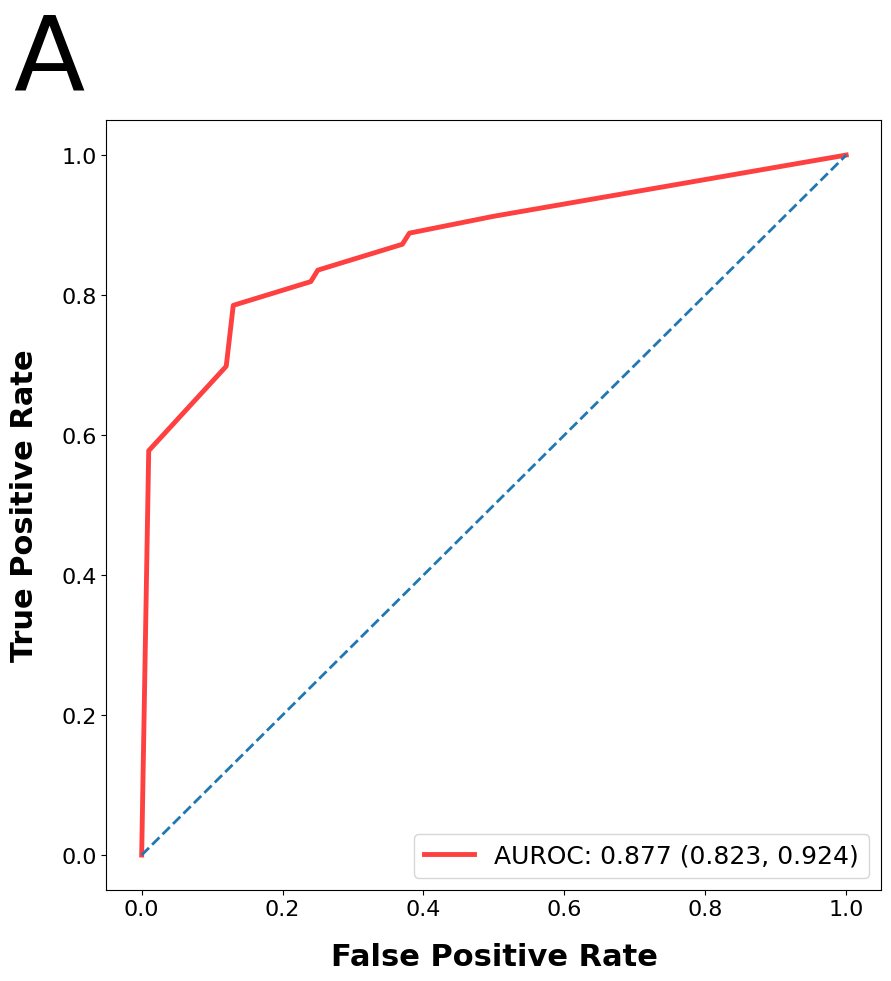

In [17]:
# Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(10)
f.set_figheight(10)

auroc_label = auroc_str

pyplot.plot(base_fpr, mean_tprs, label=auroc_label, color='r', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('A', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/HCMP-ML/roc.jpg', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


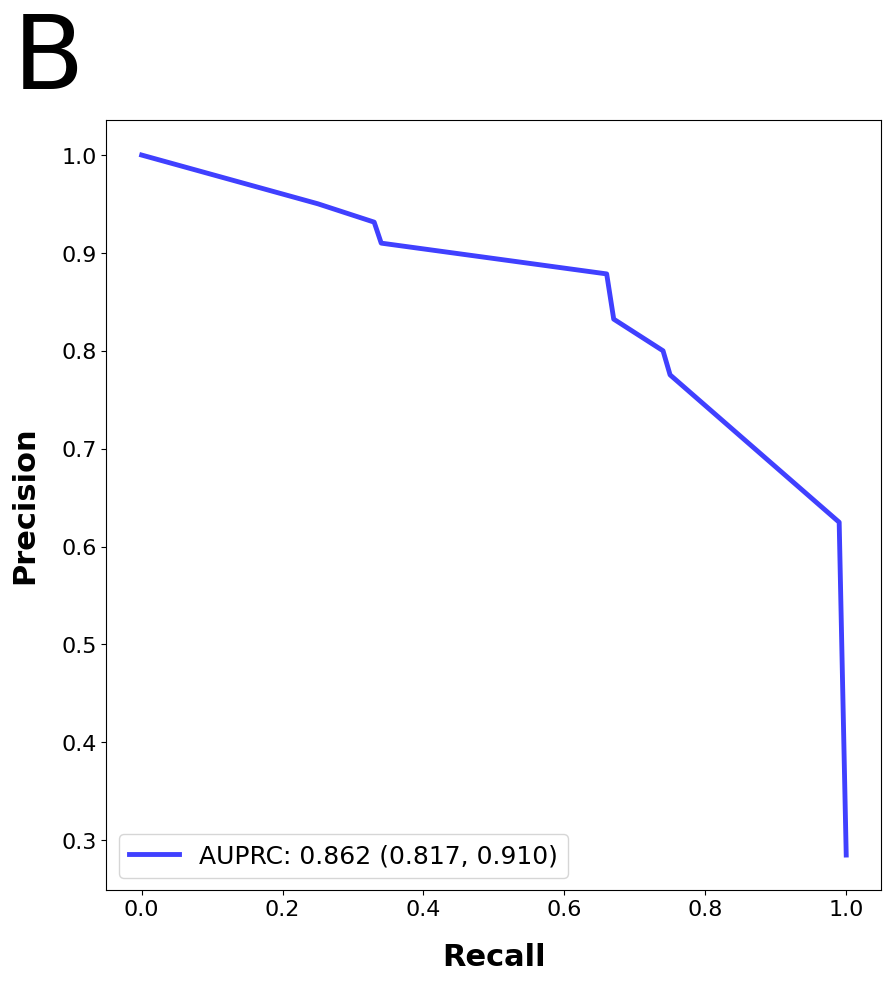

In [18]:
# Plot PR curve.

f = pyplot.figure()
f.set_figwidth(10)
f.set_figheight(10)

auprc_label = auprc_str

pyplot.plot(base_fpr, mean_prcs, label=auprc_label, color = 'b', linewidth = 3.5, alpha = 0.75)


pyplot.title('B', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower left', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/HCMP-ML/prc.jpg', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


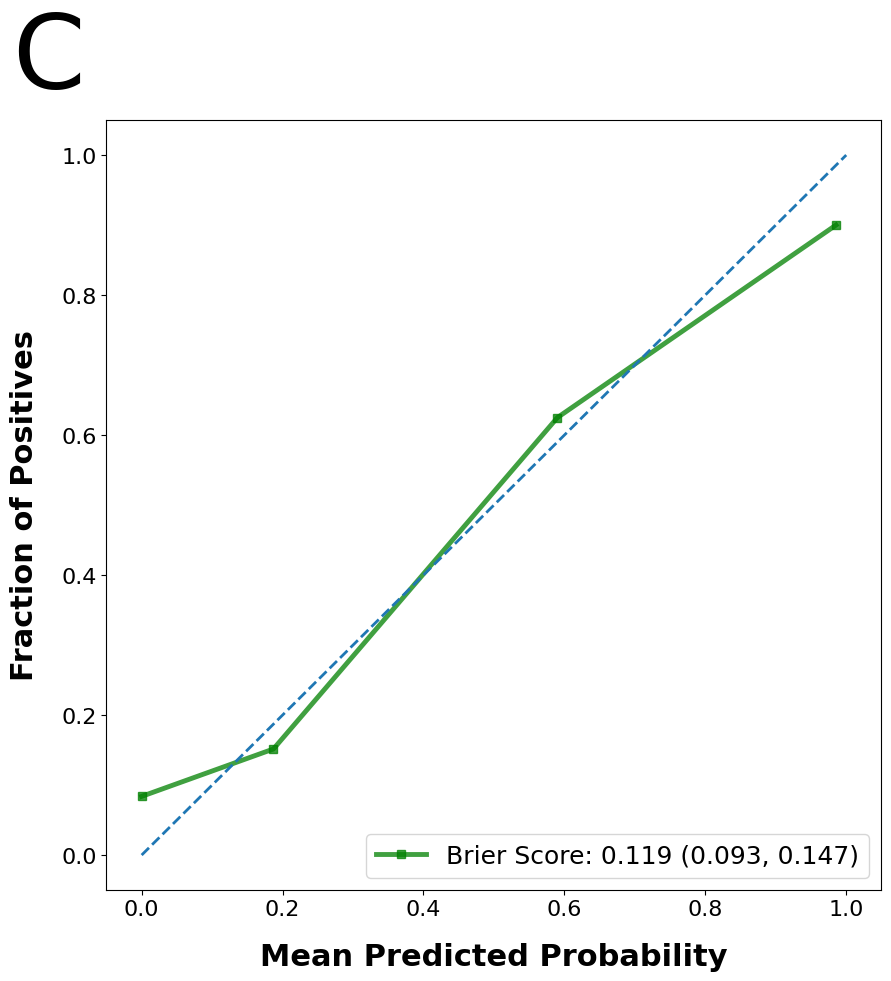

In [19]:
# Plot Calibration curve.

f = pyplot.figure()
f.set_figwidth(10)
f.set_figheight(10)

brier_label = brier_str

pyplot.plot(mean_predicted_value, fraction_of_positives, 's-', label=brier_label, color='g', linewidth=3.5, alpha=0.75)
pyplot.plot([0, 1], [0, 1], linestyle='--', linewidth=2)

pyplot.title('C', x=-0.075, y=1.005, fontsize=75, pad=20)
pyplot.xlabel('Mean Predicted Probability', fontsize=22, fontweight='heavy', labelpad=16)
pyplot.ylabel('Fraction of Positives', fontsize=22, fontweight='heavy', labelpad=16)
pyplot.tick_params(axis="y", direction="out", labelsize=16)
pyplot.tick_params(axis="x", direction="out", labelsize=16)

leg = pyplot.legend(loc='lower right', fontsize=18)

pyplot.savefig('/content/drive/MyDrive/HCMP-ML/calibration.jpg', dpi=300)
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


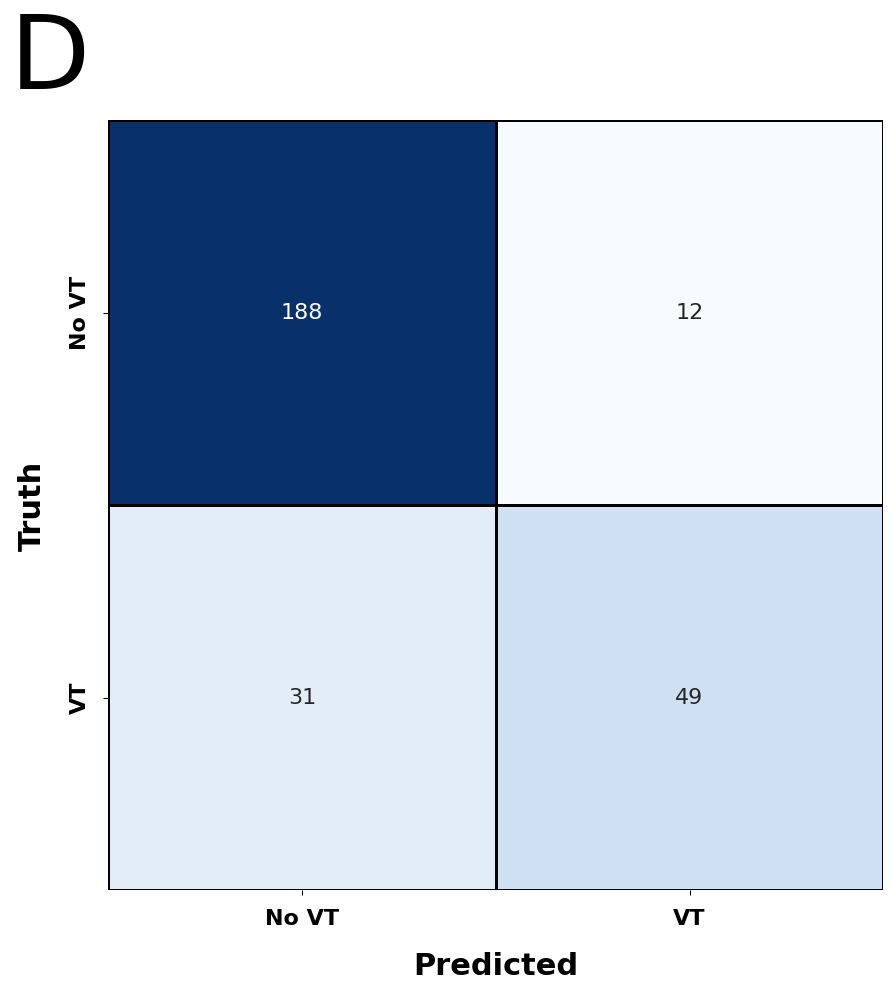

In [20]:
# Plot the aggregate confusion matrix
f = pyplot.figure(figsize=(10, 10))
aggregate_cm = aggregate_cm.astype(int)
sns.heatmap(aggregate_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16}, linewidths=1, linecolor='black')

labels = ['No VT', 'VT']
pyplot.xticks([0.5, 1.5], labels, fontsize=16, fontweight='heavy')
pyplot.yticks([0.5, 1.5], labels, fontsize=16, fontweight='heavy', va='center')

pyplot.xlabel('Predicted', fontsize=22, fontweight='heavy', labelpad=16)
pyplot.ylabel('Truth', fontsize=22, fontweight='heavy', labelpad=16)

pyplot.tick_params(axis="y", direction="out", pad=10)
pyplot.tick_params(axis="x", direction="out", pad=10)
pyplot.title('D', x=-0.075, y=1.005, fontsize=75, pad=20)

pyplot.savefig('/content/drive/MyDrive/HCMP-ML/aggregate_cm.jpg', dpi=300)
pyplot.show()

In [21]:
roc = cv2.imread('/content/drive/MyDrive/HCMP-ML/roc.jpg')
prc = cv2.imread('/content/drive/MyDrive/HCMP-ML/prc.jpg')
cal = cv2.imread('/content/drive/MyDrive/HCMP-ML/calibration.jpg')
cm = cv2.imread('/content/drive/MyDrive/HCMP-ML/aggregate_cm.jpg')

fig1 = cv2.hconcat([roc, prc])
fig2 = cv2.hconcat([cal, cm])

fig = cv2.vconcat([fig1, fig2])

cv2_imshow(fig)

cv2.imwrite('/content/drive/MyDrive/HCMP-ML/fig.jpg', fig, [cv2.IMWRITE_JPEG_QUALITY, 100])

Output hidden; open in https://colab.research.google.com to view.

# SHAP

In [22]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [23]:
#Calculate SHAP values.

explainer = shap.Explainer(calibrated.predict, x[selected_features_final])
shap_values = explainer(x[selected_features_final])

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_GenerativeAIImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()
_PyDrive2ImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_GenerativeAIImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; 

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


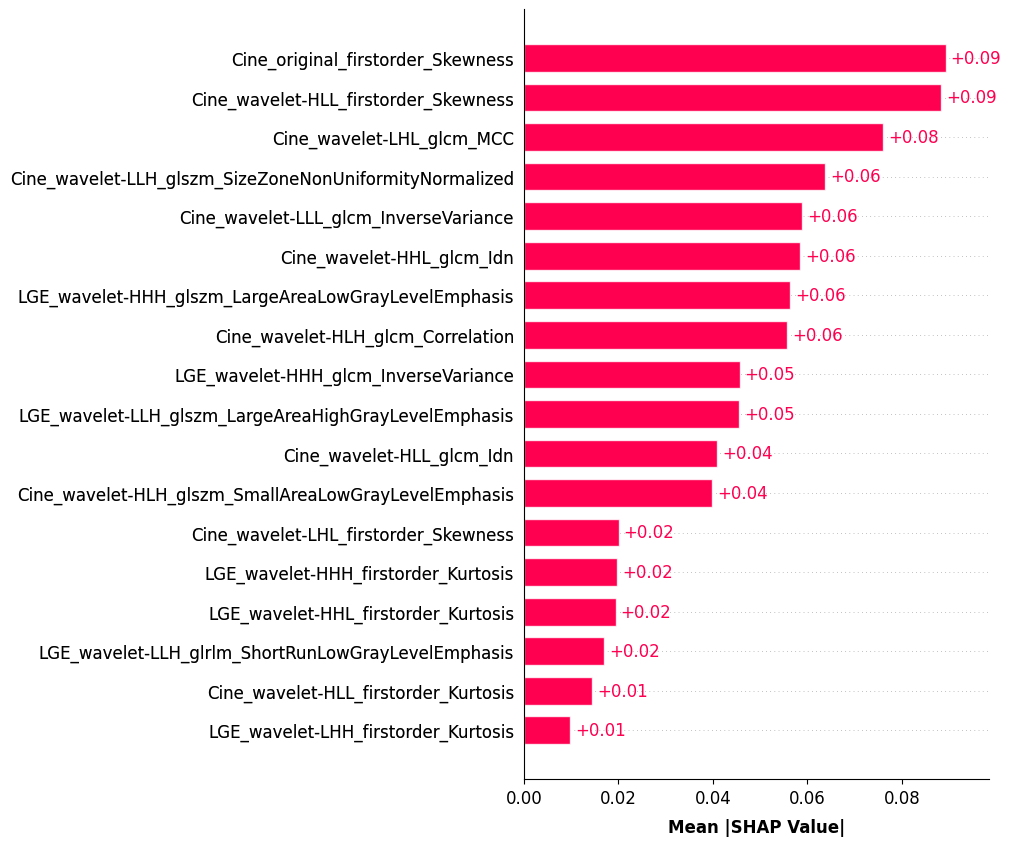

In [24]:
#Plot SHAP bar plot.

shap.plots.bar(shap_values, max_display = 25, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(10)
fig.set_figwidth(6)

pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

#wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/HCMP-ML/shap.jpg', dpi=300, bbox_inches='tight')